# Introduction

UNet has long been considered a traditional yet effective technique for image segmentation. However, with the rapid advancement of deep learning, many state-of-the-art segmentation methods have emerged in recent years. This raises an interesting question: is it possible to train a traditional UNet in such a way that it performs comparably to or even better than these newer methods? In this context, it becomes important to consider whether the choice of loss functions and fine-tuning strategies might play a more critical role than simply relying on a more sophisticated model architecture.

To address this question, we implemented a UNet model, then compared its performance with two state-of-the-art techniques: TransUNet and SwinUNETR. Our experiments were conducted using a dataset sourced from Kaggle, originally provided by The Cancer Imaging Archive (TCIA), consisting of brain MRI scans from 110 patients. Each patient has between 20 to 50 slices, totaling 3,929 brain images and corresponding masks, each with a resolution of 256×256 pixels.

In [ ]:
# import necessary libraries
import os
from glob import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Data pre-processing

All images were stored in TIF format, with each patient's data organized in a separate folder containing both brain images and their corresponding mask images. The mask images are easily identifiable by the inclusion of "_mask" in their filenames. To manage the data efficiently, we created a DataFrame containing the file paths of each brain image and its corresponding mask. Using these paths, we loaded the images as tensors. Since the brain images are in RGB, they were loaded as 3-channel tensors, while the masks, being grayscale, were loaded as single-channel tensors. During the loading process, we normalized the pixel values by dividing by 255, scaling them from a range of 0–255 to 0–1. For the mask images, we applied a binarization step where all pixel values greater than or equal to 0.5 were set to white, and the rest to black, to ensure clear and precise masking.

In [ ]:
# Create dataframe which stores path of every images and masks
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = '../data/kaggle_3m'
df = create_df(data_dir)
df.head()

,images,masks
0,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
1,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
2,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
3,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...
4,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...,../data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_C...


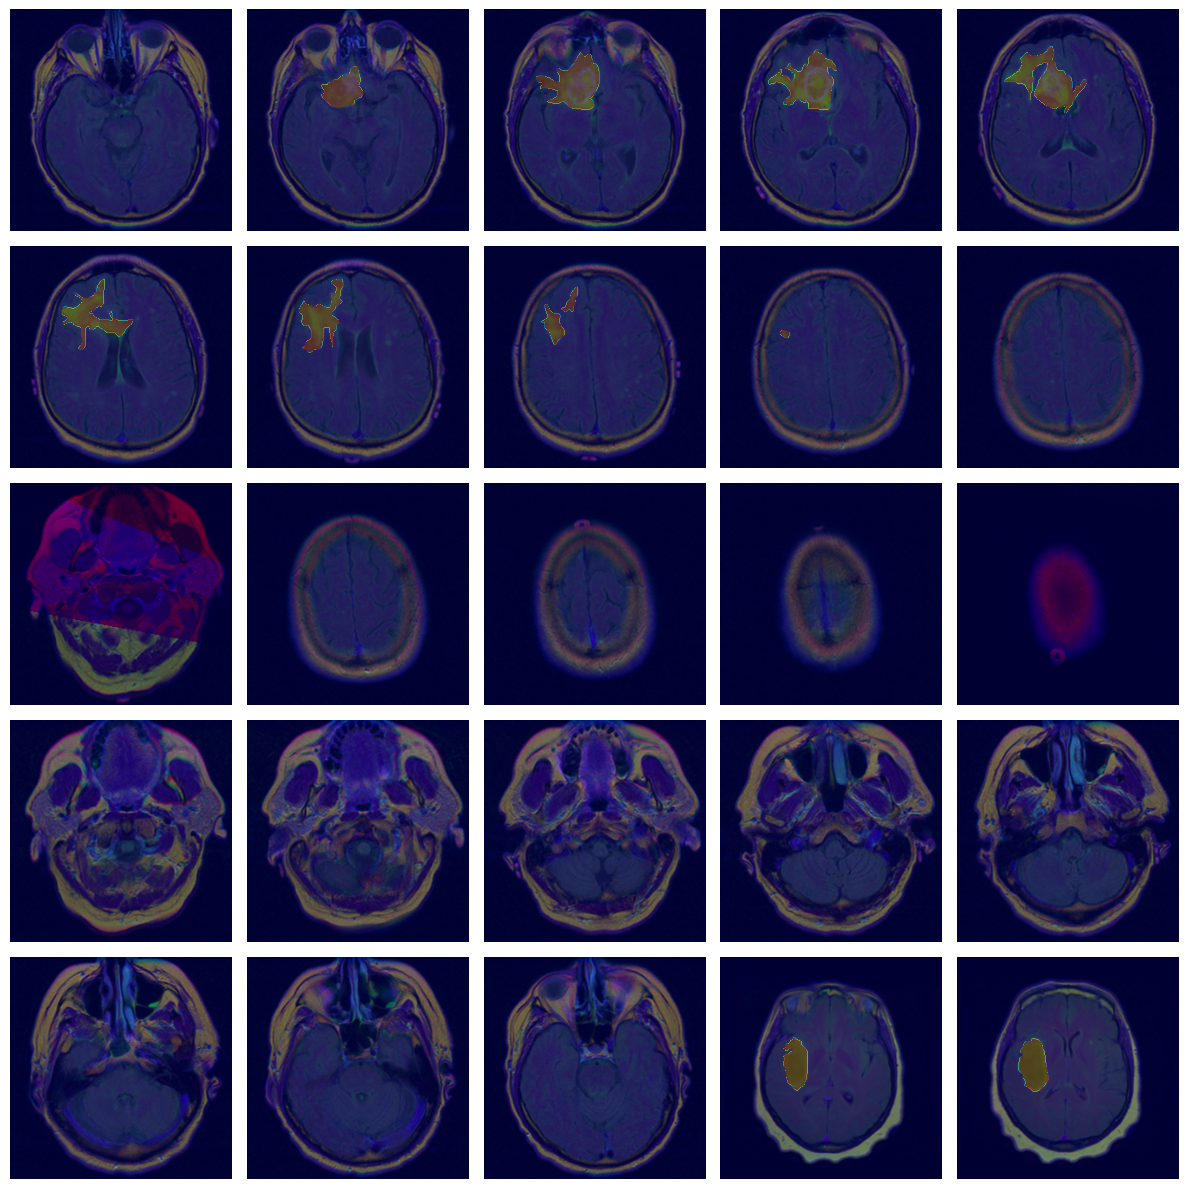

In [ ]:
# Load images to make sure they are properly showing
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)

        img_path = images[i]
        mask_path = masks[i]

        # Read and convert image to RGB
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Read the mask
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

        # Display the image
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.4) 
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(list(df["images"]), list(df["masks"]))

In [ ]:
# Load images and masks to tensors and normalize (+ binarize)
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk
    
def img_to_tensor(df, mask=False):
    if mask:
        transform = transforms.Compose([
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),          
            #MaskBinarize()
        ])
    
    image_tensors = []
    
    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
            else:
                img = Image.open(img_path).convert("RGB")  # RGB transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        # (batch, C, H, W)
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors
    else:
        print("No valid images were loaded.")
        return None

image_tensors = img_to_tensor(df["images"])
mask_tensors = img_to_tensor(df["masks"], mask=True)

if image_tensors is not None:
    print(f"Final tensor shape: {image_tensors.shape}")  # (N, C, H, W)


Loaded 3929 images successfully.
Loaded 3929 images successfully.
Final tensor shape: torch.Size([3929, 3, 256, 256])


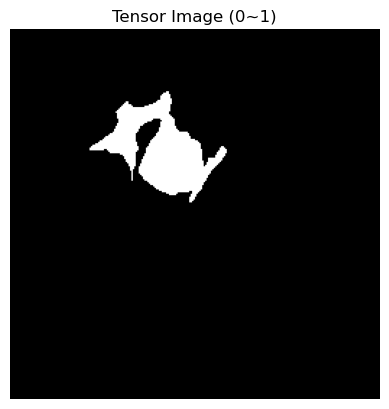

In [ ]:
# print one mask tensor to check

np_img = mask_tensors[4].permute(1, 2, 0).numpy()  

plt.imshow(np_img)
plt.axis('off')
plt.title("Tensor Image (0~1)")
plt.show()

In [6]:
# data split: 80/10/10
train_img, test_img, train_mask, test_mask = train_test_split(image_tensors, mask_tensors, test_size = 0.1)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1)

In [ ]:
# Create dataset and dataloader
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Model setup

Here, we implement UNET. 
- Structure

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, sigmoid
from datetime import datetime

In [10]:
class UNet(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()

        # Encoder - Downsample input images using max-pooling (256x256x3 images)
        self.e11 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e12 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e22 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e32 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e42 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e52 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding)


        # Decoder - Upsampling using transposed convolution
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d12 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d22 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d32 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d42 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)


        # Output
        self.output = nn.Conv2d(32, 1, kernel_size=1)


    # Input processing through the model
    def forward(self, x):
        # Encoder
        e11 = relu(self.e11(x))
        e12 = relu(self.e12(e11))
        maxpool1 = self.maxpool1(e12)

        e21 = relu(self.e21(maxpool1))
        e22 = relu(self.e22(e21))
        maxpool2 = self.maxpool2(e22)

        e31 = relu(self.e31(maxpool2))
        e32 = relu(self.e32(e31))
        maxpool3 = self.maxpool3(e32)

        e41 = relu(self.e41(maxpool3))
        e42 = relu(self.e42(e41))
        maxpool4 = self.maxpool4(e42)

        e51 = relu(self.e51(maxpool4))
        e52 = relu(self.e52(e51))

        # Decoder
        upconv1 = self.upconv1(e52)
        upconv1 = torch.cat([upconv1, e42], dim=1)
        d11 = self.d11(upconv1)
        d12 = self.d12(d11)

        upconv2 = self.upconv2(e42)
        upconv2 = torch.cat([upconv2, e32], dim=1)
        d21 = self.d21(upconv2)
        d22 = self.d22(d21)

        upconv3 = self.upconv3(d22)
        upconv3 = torch.cat([upconv3, e22], dim=1)
        d31 = self.d31(upconv3)
        d32 = self.d32(d31)

        upconv4 = self.upconv4(d32)
        upconv4 = torch.cat([upconv4, e12], dim=1)
        d41 = self.d41(upconv4)
        d42 = self.d42(d41)

        out = self.output(d42)
        out = sigmoid(out)

        return out

# Hyperparameter tuning

We focused on tuning the number of epochs and the BCE loss weight. Initially, the loss continued to decrease steadily up to the 99th and 100th epochs with a 100-epoch setting, prompting us to extend the training to 200 epochs and apply early stopping with a patience of 50. However, no further improvement was observed after the 130th epoch, leading to early stopping being triggered at the 180th epoch, where the model achieved strong performance. We also experimented with different BCE loss weights—0.3, 0.5, and 0.8—and found that a weight of 0.5 yielded the best results.

In [ ]:
# parameter setup
folder_path = './models'

kernel_size = 3
stride = 1
padding = 1

num_epochs = 200
patience = 50

bce_weight = 0.5 # Coefficient for Binary Cross Entropy loss in loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# loss function setup
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return bce_weight * bce_loss + (1-bce_weight) * dice_loss
        

In [12]:
model = UNet(kernel_size, stride, padding)
model.to(device)

UNet(
  (e11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(256, 512, kernel

In [ ]:
# train UNET
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss(bce_weight=0.5)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in trainloader:
        optimizer.zero_grad(set_to_none=True)
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        loss = 0
        loss += criterion(pred_mask, true_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valloader:
            optimizer.zero_grad(set_to_none=True)
            images, true_mask = batch
            images = images.to(device)
            true_mask = true_mask.to(device)

            pred_mask = model(images)

            loss = 0
            loss += criterion(pred_mask, true_mask)
            val_loss += loss.item()
        
    avg_val_loss = val_loss / len(valloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"{folder_path}/best_model_{str(best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

        
            

Epoch 1/200 - Train Loss: 0.6611 - Validation Loss: 0.5313
Validation loss improved. Best model updated.
Epoch 2/200 - Train Loss: 0.5176 - Validation Loss: 0.4813
Validation loss improved. Best model updated.
Epoch 3/200 - Train Loss: 0.4269 - Validation Loss: 0.3177
Validation loss improved. Best model updated.
Epoch 4/200 - Train Loss: 0.3132 - Validation Loss: 0.2455
Validation loss improved. Best model updated.
Epoch 5/200 - Train Loss: 0.2854 - Validation Loss: 0.2410
Validation loss improved. Best model updated.
Epoch 6/200 - Train Loss: 0.2669 - Validation Loss: 0.2173
Validation loss improved. Best model updated.
Epoch 7/200 - Train Loss: 0.2644 - Validation Loss: 0.2098
Validation loss improved. Best model updated.
Epoch 8/200 - Train Loss: 0.2614 - Validation Loss: 0.2108
No improvement for 1 epoch(s).
Epoch 9/200 - Train Loss: 0.2391 - Validation Loss: 0.2246
No improvement for 2 epoch(s).
Epoch 10/200 - Train Loss: 0.2403 - Validation Loss: 0.2078
Validation loss improved.

In [14]:
# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Best model saved to ./models/best_model_0.06858640909194946_20250420_121526.pth


# Results

This section presents the performance of our model in terms of Dice coefficient, IoU, and Recall. We achieved notably high scores across these metrics, and visual inspection of the predicted masks showed a strong resemblance to the ground truth masks, further confirming the effectiveness of our approach.

In [ ]:
# test UNET
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.eval()

pred_mask_all, true_mask_all = [], []

with torch.no_grad():
    for batch in testloader:
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        true_mask_all.append(true_mask.cpu().numpy())
                             
    preds = np.concatenate(pred_mask_all, axis=0)   # shape: (N, H, W) or (N, 1, H, W)
    trues = np.concatenate(true_mask_all, axis=0)        

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")



 **Test Results:**
Dice Coefficient: 0.8907
IoU: 0.8029
Recall: 0.9007


In [ ]:
# Let's see the visualized results!
def show_brain_masks(images: torch.Tensor,
                     true_masks: torch.Tensor,
                     pred_masks: torch.Tensor,
                     n_rows: int = 5):
    """
    images:     torch.Tensor of shape (N, C, H, W) or (N, H, W, C), pixel value range [0,1] or [0,255]
    true_masks: torch.Tensor of shape (N, 1, H, W) or (N, H, W), 0/1 or 0~255
    pred_masks: torch.Tensor of same shape as true_masks
    n_rows:     sample number to print (default: 5)
    """
    # 1. pick the masks that has white part (which actually has a tumor)
    tm = true_masks
    if tm.dim() == 4 and tm.shape[1] == 1:
        tm = tm.squeeze(1)
    has_white = (tm > 0).view(tm.shape[0], -1).any(dim=1)
    idxs = torch.nonzero(has_white, as_tuple=False).flatten()
    if idxs.numel() == 0:
        print("There are no masks with white part")
        return

    # 2. select 5 samples
    idxs = idxs[5:5+n_rows]

    # 3. Plot
    fig, axes = plt.subplots(n_rows, 3, figsize=(9, 3 * n_rows))
    for row, idx in enumerate(idxs):
        # brain MRI
        img = images[idx]
        # (C,H,W) → (H,W,C)
        if img.dim() == 3 and img.shape[0] in (1,3):
            img = img.permute(1,2,0)
        img_np = img.detach().cpu().numpy()
        # [0,255] → [0,1]
        if img_np.max() > 1.0:
            img_np = img_np / 255.0

        ax = axes[row, 0]
        # if it's grayscale image
        if img_np.ndim == 2 or img_np.shape[2] == 1:
            ax.imshow(img_np.squeeze(), cmap="gray")
        else:
            ax.imshow(img_np)
        ax.set_title("Brain MRI")
        ax.axis("off")

        # ground truth
        tm_i = tm[idx].detach().cpu().numpy()
        ax = axes[row, 1]
        ax.imshow(tm_i, cmap="gray")
        ax.set_title("ground truth")
        ax.axis("off")

        # predicted mask
        pm = pred_masks[idx]
        if pm.dim() == 3 and pm.shape[0] == 1:
            pm = pm.squeeze(0)
        pm_np = pm.detach().cpu().numpy()
        ax = axes[row, 2]
        ax.imshow(pm_np, cmap="gray")
        ax.set_title("prediction")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

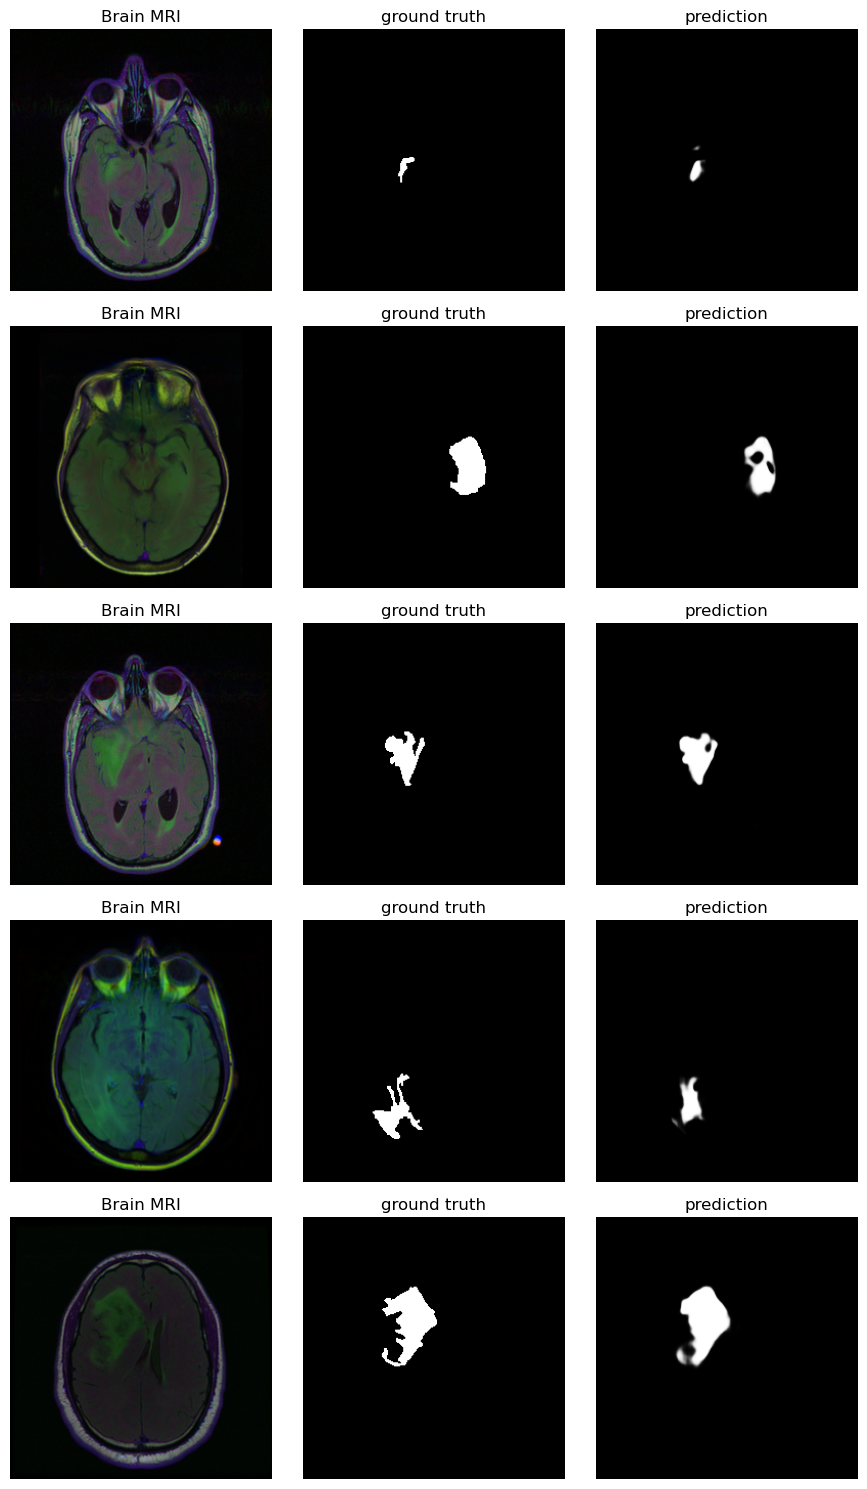

In [ ]:
test_batch, true_mask_batch = next(iter(testloader))
test_batch = test_batch.to(device)
pred_mask = model(test_batch)
show_brain_masks(test_batch, true_mask_batch, pred_mask)

# Discussion 

Our UNet outperformed the state-of-the-art models in our experiments, demonstrating strong segmentation performance on the given dataset. However, its effectiveness did not generalize well to other datasets, indicating limitations in its adaptability. As future work, we aim to develop a more generalizable model that can maintain high performance across diverse datasets.